# Titanic Kaggle Competition - Model Development

The purpose of this notebook is to train a machine learning model to predict which passengers survived the infamous sinking of the Titanic.

Author: Finian O'Neill

**Steps:**
* Preprocessing and exploring
    - Imports
    - Feature Engineering
    - Missing Values
    - Prepare for models
    - Exploring
* Model Development
    - Model Training
    - Cross Validation
    - Ensemble
* Submission

### Dependencies and Setup

In [1]:
# data wrangling
import pandas as pd
import numpy as np

# machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV

# visualization
import matplotlib.pyplot as plt

### Custom Functions and Objects

In [2]:
class Switcher(object):
    #--------------------------------------------
    #-----------------Cabin----------------------
    #--------------------------------------------
    def cabin_to_floor(self, argument):
        method_name = 'cabin_' + str(argument)
        # Get the method from 'self'. Default to a lambda.
        method = getattr(self, method_name, lambda: 9)
        # Call the method as we return it
        return method()
 
    def cabin_A(self):
        return 1
    
    def cabin_B(self):
        return 2
    
    def cabin_C(self):
        return 3
    
    def cabin_D(self):
        return 4
    
    def cabin_E(self):
        return 5
    
    def cabin_F(self):
        return 6

    def cabin_G(self):
        return 7

    def cabin_H(self):
        return 8
    
    #--------------------------------------------
    #-----------------Title----------------------
    #--------------------------------------------
    #"Capt":       "Officer"
    #"Col":        "Officer"
    #"Major":      "Officer"
    #"Jonkheer":   "Royalty",
    #"Don":        "Royalty",
    #"Sir" :       "Royalty",
    #"Dr":         "Officer",
    #"Rev":        "Officer",
    #"the Countess":"Royalty",
    #"Dona":       "Royalty",
    #"Mme":        "Mrs",
    #"Mlle":       "Miss",
    #"Ms":         "Mrs",
    #"Mr" :        "Mr",
    #"Mrs" :       "Mrs",
    #"Miss" :      "Miss",
    #"Master" :    "Master",
    #"Lady" :      "Royalty"
    def title_to_class(self, argument):
        method_name = 'title_' + str(argument)
        # Get the method from 'self'. Default to a lambda.
        method = getattr(self, method_name, lambda: "Invalid title")
        # Call the method as we return it
        return method()
    
    def title_Capt(self):
        return "Officer"
    
    def title_Col(self):
        return "Officer"
    
    def title_Major(self):
        return "Officer"
    
    def title_Jonkheer(self):
        return "Royalty"
    
    def title_Don(self):
        return "Royalty"
    
    def title_Sir(self):
        return "Royalty"

    def title_Dr(self):
        return "Officer"

    def title_Rev(self):
        return "Officer"
    
    def title_the_Countess(self):
        return "Royalty"
    
    def title_Dona(self):
        return "Royalty"
    
    def title_Mme(self):
        return "Mrs"
    
    def title_Mlle(self):
        return "Miss"

    def title_Ms(self):
        return "Mrs"
    
    def title_Mr(self):
        return "Mr"
    
    def title_Mrs(self):
        return "Mrs"
    
    def title_Miss(self):
        return "Miss"
    
    def title_Master(self):
        return "Master"
    
    def title_Lady(self):
        return "Royalty"

## Preprocessing and Exploring

### Data Load

In [3]:
# load in the data into pandas dataframes
train_df = pd.read_csv("../data/train.csv")
test_df = pd.read_csv("../data/test.csv")

In [4]:
# save PassengerId for final submission
passengerId = test_df["PassengerId"]

In [5]:
# merge train and test
total_df = train_df.append(test_df, ignore_index=True)

/Users/finianoneill/anaconda3/envs/PythonData/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


In [6]:
# create indexes to separate data later on
train_index = len(train_df)
test_index = len(total_df) - len(test_df)

### Data Exploration

In [7]:
total_df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [8]:
# get info on features
total_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


### Feature Engineering

##### Floor

In [9]:
# create a feature for the floor of the ship based on the "Cabin" number
# Hypothesis: those situated towards the bottom of the boat would have a harder time surviving
# loop through the "Cabin" column and assign a floor based on the following mapping:
# Cabin A --> 1
# Cabin B --> 2
# Cabin C --> 3
# Cabin D --> 4
# Cabin E --> 5
# Cabin F --> 6
# Cabin G --> 7
# Cabin H --> 8
cabin_floor_list = []
for index, row in total_df.iterrows():
    current_switcher = Switcher()
    try:
        cabin_floor_list.append(current_switcher.cabin_to_floor(str(row["Cabin"][0])))
    except:
        cabin_floor_list.append(0)
        
# insert mapped cabins to floors into the training dataframe
total_df["Floor"] = cabin_floor_list

# drop the "Cabin" column
total_df = total_df.drop(columns=["Cabin"])

In [10]:
# view value counts for the normalized titles
print(total_df["Floor"].value_counts())

0    1014
3      94
2      65
4      46
5      41
1      22
6      21
7       5
9       1
Name: Floor, dtype: int64


##### Title

In [11]:
# extract title names from the Name column
title_names_series = total_df["Name"].apply(lambda name: name.split(',')[1].split('.')[0].strip())

In [12]:
# create a feature for title
title_list = []
for value in title_names_series:
    current_title = value
    if current_title == "the Countess":
        current_title = "the_Countess"
    current_switcher = Switcher()
    try:
        title_list.append(current_switcher.title_to_class(current_title))
    except:
        title_list.append(0)
        
# insert mapped cabins to floors into the training dataframe
total_df["Title"] = title_list

# drop the "Name" column
total_df = total_df.drop(columns=["Name"])

In [13]:
# view value counts for the normalized titles
print(total_df["Title"].value_counts())

Mr         757
Miss       262
Mrs        200
Master      61
Officer     23
Royalty      6
Name: Title, dtype: int64


##### Family Size

In [14]:
# size of families (including the passenger)
total_df["FamilySize"] = total_df["Parch"] + total_df["SibSp"] + 1

### Fill Missing Values

##### Age

In [15]:
# fill in missing age values by grouping by sex, Pclass and title
grouped_age = total_df.groupby(['Sex','Pclass', 'Title'])

# view the median Age by the grouped features 
grouped_age["Age"].median()

Sex     Pclass  Title  
female  1       Miss       30.0
                Mrs        45.0
                Officer    49.0
                Royalty    39.0
        2       Miss       20.0
                Mrs        30.0
        3       Miss       18.0
                Mrs        31.0
male    1       Master      6.0
                Mr         41.5
                Officer    52.0
                Royalty    40.0
        2       Master      2.0
                Mr         30.0
                Officer    41.5
        3       Master      6.0
                Mr         26.0
Name: Age, dtype: float64

In [16]:
# apply the grouped median value on the Age NaN
total_df["Age"] = grouped_age["Age"].apply(lambda x: x.fillna(x.median()))

##### Embarked

In [17]:
# find most frequent Embarked value and store in variable
most_embarked = total_df["Embarked"].value_counts().index[0]

In [18]:
# fill NaN with most_embarked value
total_df["Embarked"] = total_df["Embarked"].fillna(most_embarked)

##### Fare

In [19]:
# fill NaN with median fare
total_df["Fare"] = total_df["Fare"].fillna(total_df["Fare"].median())

In [20]:
# check the missing values via info
total_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
Age            1309 non-null float64
Embarked       1309 non-null object
Fare           1309 non-null float64
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
Floor          1309 non-null int64
Title          1309 non-null object
FamilySize     1309 non-null int64
dtypes: float64(3), int64(6), object(4)
memory usage: 133.0+ KB


### Prepare for Models

In [21]:
# Convert the male and female groups to integer form
total_df["Sex"] = total_df["Sex"].map({"male": 0, "female":1})

In [22]:
# create dummy variables for categorical features
pclass_dummies = pd.get_dummies(total_df["Pclass"], prefix="Pclass")
title_dummies = pd.get_dummies(total_df["Title"], prefix="Title")
floor_dummies = pd.get_dummies(total_df["Floor"], prefix="Floor")
embarked_dummies = pd.get_dummies(total_df["Embarked"], prefix="Embarked")

# concatenate dummy columns with main dataset
total_df_dummies = pd.concat([total_df, pclass_dummies, title_dummies, floor_dummies, embarked_dummies], axis=1)

In [23]:
# drop categorical fields
total_df_dummies.drop(['Pclass', 'Title', 'Floor', 'Embarked', 'Ticket', 'PassengerId'], axis=1, inplace=True)

total_df_dummies.head()

,Age,Fare,Parch,Sex,SibSp,Survived,FamilySize,Pclass_1,Pclass_2,Pclass_3,...,Floor_2,Floor_3,Floor_4,Floor_5,Floor_6,Floor_7,Floor_9,Embarked_C,Embarked_Q,Embarked_S
0,22.0,7.2500,0,0,1,0.0,2,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,38.0,71.2833,0,1,1,1.0,2,1,0,0,...,0,1,0,0,0,0,0,1,0,0
2,26.0,7.9250,0,1,0,1.0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,35.0,53.1000,0,1,1,1.0,2,1,0,0,...,0,1,0,0,0,0,0,0,0,1
4,35.0,8.0500,0,0,0,0.0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [24]:
# create train and test data
train = total_df_dummies.iloc[ :train_index]
test = total_df_dummies.iloc[test_index: ]

# convert Survived back to int
train["Survived"] = train["Survived"].astype(int)

# create X and y for data and target values 
X = train.drop("Survived", axis=1).values 
y = train["Survived"].values
# create array for test set
X_test = test.drop("Survived", axis=1).values

/Users/finianoneill/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


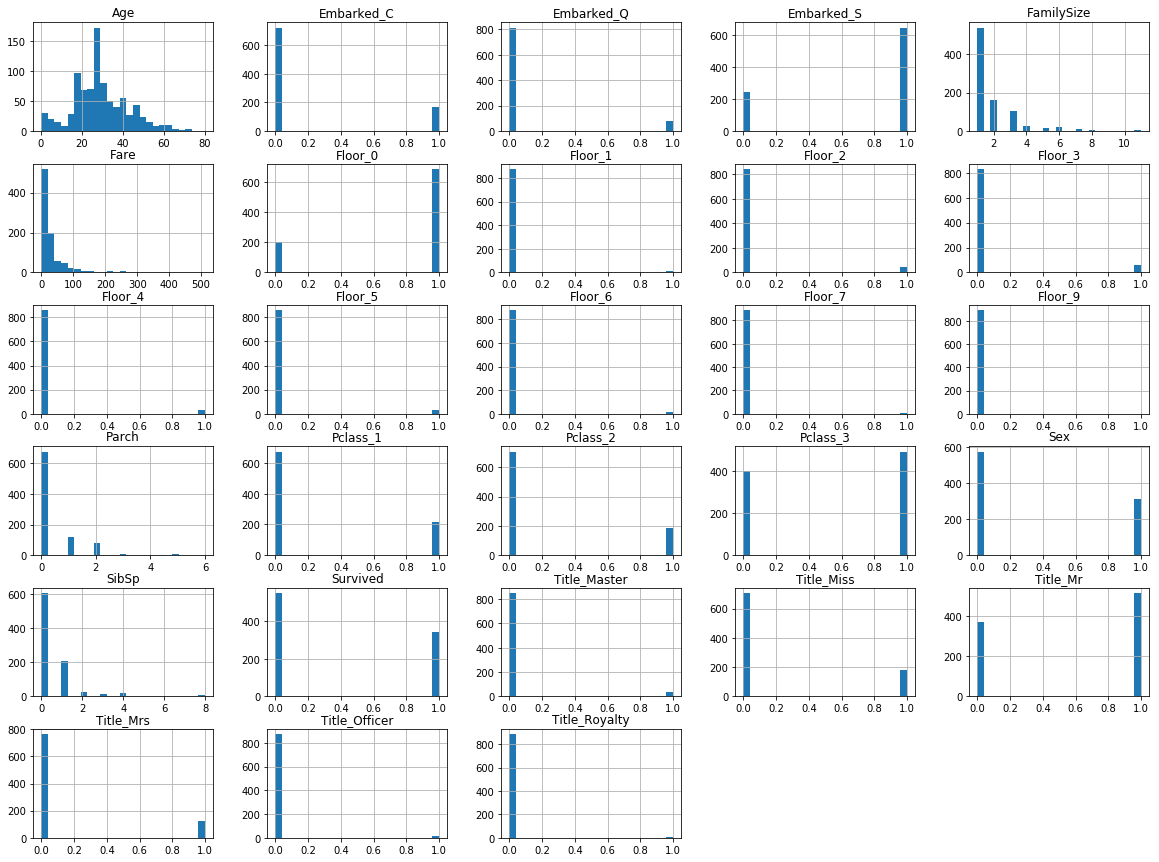

In [25]:
# create histogram of train set
train_feature_hist = train.hist(bins=25, figsize=(20,15))

## Model Development

### Random Forest

In [26]:
# create param grid object 
forest_params = dict(     
    max_depth = [n for n in range(9, 14)],     
    min_samples_split = [n for n in range(4, 11)], 
    min_samples_leaf = [n for n in range(2, 5)],     
    n_estimators = [n for n in range(10, 60, 10)],
)

In [27]:
# instantiate Random Forest model
forest_clf = RandomForestClassifier()

In [28]:
# build and fit model 
forest_cv = GridSearchCV(estimator=forest_clf, param_grid=forest_params, cv=5, verbose=2) 
forest_cv.fit(X, y)

Fitting 5 folds for each of 525 candidates, totalling 2625 fits
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=4, n_estimators=10 
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=4, n_estimators=10, total=   0.0s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=4, n_estimators=10 
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=4, n_estimators=10, total=   0.0s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=4, n_estimators=10 
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=4, n_estimators=10, total=   0.0s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=4, n_estimators=10 
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=4, n_estimators=10, total=   0.0s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=4, n_estimators=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=4, n_estimators=10, total=   0.0s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=4, n_estimators=20 
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=4, n_estimators=20, total=   0.1s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=4, n_estimators=20 
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=4, n_estimators=20, total=   0.1s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=4, n_estimators=20 
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=4, n_estimators=20, total=   0.1s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=4, n_estimators=20 
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=4, n_estimators=20, total=   0.0s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=4, n_estimators=20 
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=4, n_estimators=20, total=   0.1s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=4, n_estimators=30

[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=6, n_estimators=20, total=   0.0s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=6, n_estimators=20 
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=6, n_estimators=20, total=   0.0s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=6, n_estimators=20 
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=6, n_estimators=20, total=   0.0s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=6, n_estimators=20 
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=6, n_estimators=20, total=   0.0s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=6, n_estimators=20 
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=6, n_estimators=20, total=   0.0s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=6, n_estimators=30 
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=6, n_estimators=30, total=   0.0s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=6, n_estimators=30

[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=8, n_estimators=20, total=   0.0s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=8, n_estimators=20 
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=8, n_estimators=20, total=   0.0s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=8, n_estimators=30 
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=8, n_estimators=30, total=   0.0s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=8, n_estimators=30 
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=8, n_estimators=30, total=   0.0s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=8, n_estimators=30 
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=8, n_estimators=30, total=   0.0s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=8, n_estimators=30 
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=8, n_estimators=30, total=   0.0s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=8, n_estimators=30

[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=10, n_estimators=30, total=   0.0s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=10, n_estimators=30 
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=10, n_estimators=30, total=   0.0s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=10, n_estimators=30 
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=10, n_estimators=30, total=   0.0s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=10, n_estimators=40 
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=10, n_estimators=40, total=   0.1s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=10, n_estimators=40 
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=10, n_estimators=40, total=   0.1s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=10, n_estimators=40 
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=10, n_estimators=40, total=   0.1s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=10, n_e

[CV]  max_depth=9, min_samples_leaf=3, min_samples_split=5, n_estimators=30, total=   0.0s
[CV] max_depth=9, min_samples_leaf=3, min_samples_split=5, n_estimators=30 
[CV]  max_depth=9, min_samples_leaf=3, min_samples_split=5, n_estimators=30, total=   0.0s
[CV] max_depth=9, min_samples_leaf=3, min_samples_split=5, n_estimators=30 
[CV]  max_depth=9, min_samples_leaf=3, min_samples_split=5, n_estimators=30, total=   0.0s
[CV] max_depth=9, min_samples_leaf=3, min_samples_split=5, n_estimators=40 
[CV]  max_depth=9, min_samples_leaf=3, min_samples_split=5, n_estimators=40, total=   0.1s
[CV] max_depth=9, min_samples_leaf=3, min_samples_split=5, n_estimators=40 
[CV]  max_depth=9, min_samples_leaf=3, min_samples_split=5, n_estimators=40, total=   0.1s
[CV] max_depth=9, min_samples_leaf=3, min_samples_split=5, n_estimators=40 
[CV]  max_depth=9, min_samples_leaf=3, min_samples_split=5, n_estimators=40, total=   0.1s
[CV] max_depth=9, min_samples_leaf=3, min_samples_split=5, n_estimators=40

[CV]  max_depth=9, min_samples_leaf=3, min_samples_split=7, n_estimators=30, total=   0.0s
[CV] max_depth=9, min_samples_leaf=3, min_samples_split=7, n_estimators=30 
[CV]  max_depth=9, min_samples_leaf=3, min_samples_split=7, n_estimators=30, total=   0.0s
[CV] max_depth=9, min_samples_leaf=3, min_samples_split=7, n_estimators=30 
[CV]  max_depth=9, min_samples_leaf=3, min_samples_split=7, n_estimators=30, total=   0.0s
[CV] max_depth=9, min_samples_leaf=3, min_samples_split=7, n_estimators=40 
[CV]  max_depth=9, min_samples_leaf=3, min_samples_split=7, n_estimators=40, total=   0.1s
[CV] max_depth=9, min_samples_leaf=3, min_samples_split=7, n_estimators=40 
[CV]  max_depth=9, min_samples_leaf=3, min_samples_split=7, n_estimators=40, total=   0.1s
[CV] max_depth=9, min_samples_leaf=3, min_samples_split=7, n_estimators=40 
[CV]  max_depth=9, min_samples_leaf=3, min_samples_split=7, n_estimators=40, total=   0.1s
[CV] max_depth=9, min_samples_leaf=3, min_samples_split=7, n_estimators=40

[CV]  max_depth=9, min_samples_leaf=3, min_samples_split=9, n_estimators=30, total=   0.0s
[CV] max_depth=9, min_samples_leaf=3, min_samples_split=9, n_estimators=30 
[CV]  max_depth=9, min_samples_leaf=3, min_samples_split=9, n_estimators=30, total=   0.0s
[CV] max_depth=9, min_samples_leaf=3, min_samples_split=9, n_estimators=30 
[CV]  max_depth=9, min_samples_leaf=3, min_samples_split=9, n_estimators=30, total=   0.0s
[CV] max_depth=9, min_samples_leaf=3, min_samples_split=9, n_estimators=40 
[CV]  max_depth=9, min_samples_leaf=3, min_samples_split=9, n_estimators=40, total=   0.1s
[CV] max_depth=9, min_samples_leaf=3, min_samples_split=9, n_estimators=40 
[CV]  max_depth=9, min_samples_leaf=3, min_samples_split=9, n_estimators=40, total=   0.1s
[CV] max_depth=9, min_samples_leaf=3, min_samples_split=9, n_estimators=40 
[CV]  max_depth=9, min_samples_leaf=3, min_samples_split=9, n_estimators=40, total=   0.1s
[CV] max_depth=9, min_samples_leaf=3, min_samples_split=9, n_estimators=40

[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=4, n_estimators=30, total=   0.0s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=4, n_estimators=30 
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=4, n_estimators=30, total=   0.0s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=4, n_estimators=30 
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=4, n_estimators=30, total=   0.0s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=4, n_estimators=40 
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=4, n_estimators=40, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=4, n_estimators=40 
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=4, n_estimators=40, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=4, n_estimators=40 
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=4, n_estimators=40, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=4, n_estimators=40

[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=6, n_estimators=30, total=   0.0s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=6, n_estimators=30 
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=6, n_estimators=30, total=   0.0s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=6, n_estimators=30 
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=6, n_estimators=30, total=   0.0s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=6, n_estimators=40 
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=6, n_estimators=40, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=6, n_estimators=40 
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=6, n_estimators=40, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=6, n_estimators=40 
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=6, n_estimators=40, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=6, n_estimators=40

[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=8, n_estimators=30, total=   0.0s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=8, n_estimators=40 
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=8, n_estimators=40, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=8, n_estimators=40 
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=8, n_estimators=40, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=8, n_estimators=40 
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=8, n_estimators=40, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=8, n_estimators=40 
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=8, n_estimators=40, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=8, n_estimators=40 
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=8, n_estimators=40, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=8, n_estimators=50

[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=10, n_estimators=30, total=   0.0s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=10, n_estimators=30 
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=10, n_estimators=30, total=   0.0s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=10, n_estimators=40 
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=10, n_estimators=40, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=10, n_estimators=40 
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=10, n_estimators=40, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=10, n_estimators=40 
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=10, n_estimators=40, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=10, n_estimators=40 
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=10, n_estimators=40, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=10, n_e

[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=30, total=   0.0s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=30 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=30, total=   0.0s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=40 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=40, total=   0.1s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=40 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=40, total=   0.1s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=40 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=40, total=   0.1s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=40 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=40, total=   0.1s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=5, n_e

[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=7, n_estimators=30, total=   0.0s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=7, n_estimators=40 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=7, n_estimators=40, total=   0.1s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=7, n_estimators=40 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=7, n_estimators=40, total=   0.1s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=7, n_estimators=40 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=7, n_estimators=40, total=   0.1s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=7, n_estimators=40 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=7, n_estimators=40, total=   0.1s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=7, n_estimators=40 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=7, n_estimators=40, total=   0.1s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=7, n_e

[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=9, n_estimators=30, total=   0.1s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=9, n_estimators=40 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=9, n_estimators=40, total=   0.1s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=9, n_estimators=40 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=9, n_estimators=40, total=   0.1s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=9, n_estimators=40 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=9, n_estimators=40, total=   0.1s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=9, n_estimators=40 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=9, n_estimators=40, total=   0.1s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=9, n_estimators=40 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=9, n_estimators=40, total=   0.1s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=9, n_e

[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=4, n_estimators=40, total=   0.1s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=4, n_estimators=40 
[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=4, n_estimators=40, total=   0.1s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=4, n_estimators=40 
[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=4, n_estimators=40, total=   0.1s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=4, n_estimators=40 
[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=4, n_estimators=40, total=   0.2s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=4, n_estimators=50 
[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=4, n_estimators=50, total=   0.2s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=4, n_estimators=50 
[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=4, n_estimators=50, total=   0.1s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=4, n_e

[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=6, n_estimators=40, total=   0.1s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=6, n_estimators=40 
[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=6, n_estimators=40, total=   0.1s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=6, n_estimators=40 
[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=6, n_estimators=40, total=   0.1s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=6, n_estimators=40 
[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=6, n_estimators=40, total=   0.1s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=6, n_estimators=50 
[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=6, n_estimators=50, total=   0.1s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=6, n_estimators=50 
[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=6, n_estimators=50, total=   0.1s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=6, n_e

[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=40, total=   0.1s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=40 
[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=40, total=   0.1s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=40 
[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=40, total=   0.1s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=40 
[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=40, total=   0.1s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=40 
[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=40, total=   0.1s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=50 
[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=50, total=   0.1s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=8, n_e

[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=40, total=   0.1s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=40 
[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=40, total=   0.1s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=40 
[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=40, total=   0.1s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=40 
[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=40, total=   0.1s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=40 
[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=40, total=   0.1s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=50 
[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] max_depth=10, min_samples_leaf=3, min_samples_s

[CV]  max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=40, total=   0.1s
[CV] max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=40 
[CV]  max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=40, total=   0.1s
[CV] max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=40 
[CV]  max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=40, total=   0.1s
[CV] max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=40 
[CV]  max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=40, total=   0.1s
[CV] max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=40 
[CV]  max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=40, total=   0.1s
[CV] max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=50 
[CV]  max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=50, total=   0.1s
[CV] max_depth=10, min_samples_leaf=4, min_samples_split=5, n_e

[CV]  max_depth=10, min_samples_leaf=4, min_samples_split=7, n_estimators=40, total=   0.1s
[CV] max_depth=10, min_samples_leaf=4, min_samples_split=7, n_estimators=40 
[CV]  max_depth=10, min_samples_leaf=4, min_samples_split=7, n_estimators=40, total=   0.1s
[CV] max_depth=10, min_samples_leaf=4, min_samples_split=7, n_estimators=40 
[CV]  max_depth=10, min_samples_leaf=4, min_samples_split=7, n_estimators=40, total=   0.1s
[CV] max_depth=10, min_samples_leaf=4, min_samples_split=7, n_estimators=40 
[CV]  max_depth=10, min_samples_leaf=4, min_samples_split=7, n_estimators=40, total=   0.1s
[CV] max_depth=10, min_samples_leaf=4, min_samples_split=7, n_estimators=40 
[CV]  max_depth=10, min_samples_leaf=4, min_samples_split=7, n_estimators=40, total=   0.1s
[CV] max_depth=10, min_samples_leaf=4, min_samples_split=7, n_estimators=50 
[CV]  max_depth=10, min_samples_leaf=4, min_samples_split=7, n_estimators=50, total=   0.1s
[CV] max_depth=10, min_samples_leaf=4, min_samples_split=7, n_e

[CV]  max_depth=10, min_samples_leaf=4, min_samples_split=9, n_estimators=40, total=   0.1s
[CV] max_depth=10, min_samples_leaf=4, min_samples_split=9, n_estimators=40 
[CV]  max_depth=10, min_samples_leaf=4, min_samples_split=9, n_estimators=40, total=   0.1s
[CV] max_depth=10, min_samples_leaf=4, min_samples_split=9, n_estimators=40 
[CV]  max_depth=10, min_samples_leaf=4, min_samples_split=9, n_estimators=40, total=   0.1s
[CV] max_depth=10, min_samples_leaf=4, min_samples_split=9, n_estimators=40 
[CV]  max_depth=10, min_samples_leaf=4, min_samples_split=9, n_estimators=40, total=   0.1s
[CV] max_depth=10, min_samples_leaf=4, min_samples_split=9, n_estimators=40 
[CV]  max_depth=10, min_samples_leaf=4, min_samples_split=9, n_estimators=40, total=   0.1s
[CV] max_depth=10, min_samples_leaf=4, min_samples_split=9, n_estimators=50 
[CV]  max_depth=10, min_samples_leaf=4, min_samples_split=9, n_estimators=50, total=   0.1s
[CV] max_depth=10, min_samples_leaf=4, min_samples_split=9, n_e

[CV]  max_depth=11, min_samples_leaf=2, min_samples_split=4, n_estimators=30, total=   0.1s
[CV] max_depth=11, min_samples_leaf=2, min_samples_split=4, n_estimators=40 
[CV]  max_depth=11, min_samples_leaf=2, min_samples_split=4, n_estimators=40, total=   0.1s
[CV] max_depth=11, min_samples_leaf=2, min_samples_split=4, n_estimators=40 
[CV]  max_depth=11, min_samples_leaf=2, min_samples_split=4, n_estimators=40, total=   0.1s
[CV] max_depth=11, min_samples_leaf=2, min_samples_split=4, n_estimators=40 
[CV]  max_depth=11, min_samples_leaf=2, min_samples_split=4, n_estimators=40, total=   0.1s
[CV] max_depth=11, min_samples_leaf=2, min_samples_split=4, n_estimators=40 
[CV]  max_depth=11, min_samples_leaf=2, min_samples_split=4, n_estimators=40, total=   0.1s
[CV] max_depth=11, min_samples_leaf=2, min_samples_split=4, n_estimators=40 
[CV]  max_depth=11, min_samples_leaf=2, min_samples_split=4, n_estimators=40, total=   0.1s
[CV] max_depth=11, min_samples_leaf=2, min_samples_split=4, n_e

[CV]  max_depth=11, min_samples_leaf=2, min_samples_split=6, n_estimators=30, total=   0.0s
[CV] max_depth=11, min_samples_leaf=2, min_samples_split=6, n_estimators=30 
[CV]  max_depth=11, min_samples_leaf=2, min_samples_split=6, n_estimators=30, total=   0.0s
[CV] max_depth=11, min_samples_leaf=2, min_samples_split=6, n_estimators=40 
[CV]  max_depth=11, min_samples_leaf=2, min_samples_split=6, n_estimators=40, total=   0.1s
[CV] max_depth=11, min_samples_leaf=2, min_samples_split=6, n_estimators=40 
[CV]  max_depth=11, min_samples_leaf=2, min_samples_split=6, n_estimators=40, total=   0.1s
[CV] max_depth=11, min_samples_leaf=2, min_samples_split=6, n_estimators=40 
[CV]  max_depth=11, min_samples_leaf=2, min_samples_split=6, n_estimators=40, total=   0.1s
[CV] max_depth=11, min_samples_leaf=2, min_samples_split=6, n_estimators=40 
[CV]  max_depth=11, min_samples_leaf=2, min_samples_split=6, n_estimators=40, total=   0.1s
[CV] max_depth=11, min_samples_leaf=2, min_samples_split=6, n_e

[CV]  max_depth=11, min_samples_leaf=2, min_samples_split=8, n_estimators=30, total=   0.0s
[CV] max_depth=11, min_samples_leaf=2, min_samples_split=8, n_estimators=40 
[CV]  max_depth=11, min_samples_leaf=2, min_samples_split=8, n_estimators=40, total=   0.1s
[CV] max_depth=11, min_samples_leaf=2, min_samples_split=8, n_estimators=40 
[CV]  max_depth=11, min_samples_leaf=2, min_samples_split=8, n_estimators=40, total=   0.1s
[CV] max_depth=11, min_samples_leaf=2, min_samples_split=8, n_estimators=40 
[CV]  max_depth=11, min_samples_leaf=2, min_samples_split=8, n_estimators=40, total=   0.1s
[CV] max_depth=11, min_samples_leaf=2, min_samples_split=8, n_estimators=40 
[CV]  max_depth=11, min_samples_leaf=2, min_samples_split=8, n_estimators=40, total=   0.1s
[CV] max_depth=11, min_samples_leaf=2, min_samples_split=8, n_estimators=40 
[CV]  max_depth=11, min_samples_leaf=2, min_samples_split=8, n_estimators=40, total=   0.1s
[CV] max_depth=11, min_samples_leaf=2, min_samples_split=8, n_e

[CV]  max_depth=11, min_samples_leaf=2, min_samples_split=10, n_estimators=30, total=   0.0s
[CV] max_depth=11, min_samples_leaf=2, min_samples_split=10, n_estimators=30 
[CV]  max_depth=11, min_samples_leaf=2, min_samples_split=10, n_estimators=30, total=   0.0s
[CV] max_depth=11, min_samples_leaf=2, min_samples_split=10, n_estimators=40 
[CV]  max_depth=11, min_samples_leaf=2, min_samples_split=10, n_estimators=40, total=   0.1s
[CV] max_depth=11, min_samples_leaf=2, min_samples_split=10, n_estimators=40 
[CV]  max_depth=11, min_samples_leaf=2, min_samples_split=10, n_estimators=40, total=   0.1s
[CV] max_depth=11, min_samples_leaf=2, min_samples_split=10, n_estimators=40 
[CV]  max_depth=11, min_samples_leaf=2, min_samples_split=10, n_estimators=40, total=   0.1s
[CV] max_depth=11, min_samples_leaf=2, min_samples_split=10, n_estimators=40 
[CV]  max_depth=11, min_samples_leaf=2, min_samples_split=10, n_estimators=40, total=   0.1s
[CV] max_depth=11, min_samples_leaf=2, min_samples_s

[CV]  max_depth=11, min_samples_leaf=3, min_samples_split=5, n_estimators=30, total=   0.0s
[CV] max_depth=11, min_samples_leaf=3, min_samples_split=5, n_estimators=30 
[CV]  max_depth=11, min_samples_leaf=3, min_samples_split=5, n_estimators=30, total=   0.0s
[CV] max_depth=11, min_samples_leaf=3, min_samples_split=5, n_estimators=40 
[CV]  max_depth=11, min_samples_leaf=3, min_samples_split=5, n_estimators=40, total=   0.1s
[CV] max_depth=11, min_samples_leaf=3, min_samples_split=5, n_estimators=40 
[CV]  max_depth=11, min_samples_leaf=3, min_samples_split=5, n_estimators=40, total=   0.1s
[CV] max_depth=11, min_samples_leaf=3, min_samples_split=5, n_estimators=40 
[CV]  max_depth=11, min_samples_leaf=3, min_samples_split=5, n_estimators=40, total=   0.1s
[CV] max_depth=11, min_samples_leaf=3, min_samples_split=5, n_estimators=40 
[CV]  max_depth=11, min_samples_leaf=3, min_samples_split=5, n_estimators=40, total=   0.1s
[CV] max_depth=11, min_samples_leaf=3, min_samples_split=5, n_e

[CV]  max_depth=11, min_samples_leaf=3, min_samples_split=7, n_estimators=30, total=   0.0s
[CV] max_depth=11, min_samples_leaf=3, min_samples_split=7, n_estimators=30 
[CV]  max_depth=11, min_samples_leaf=3, min_samples_split=7, n_estimators=30, total=   0.0s
[CV] max_depth=11, min_samples_leaf=3, min_samples_split=7, n_estimators=40 
[CV]  max_depth=11, min_samples_leaf=3, min_samples_split=7, n_estimators=40, total=   0.1s
[CV] max_depth=11, min_samples_leaf=3, min_samples_split=7, n_estimators=40 
[CV]  max_depth=11, min_samples_leaf=3, min_samples_split=7, n_estimators=40, total=   0.1s
[CV] max_depth=11, min_samples_leaf=3, min_samples_split=7, n_estimators=40 
[CV]  max_depth=11, min_samples_leaf=3, min_samples_split=7, n_estimators=40, total=   0.1s
[CV] max_depth=11, min_samples_leaf=3, min_samples_split=7, n_estimators=40 
[CV]  max_depth=11, min_samples_leaf=3, min_samples_split=7, n_estimators=40, total=   0.1s
[CV] max_depth=11, min_samples_leaf=3, min_samples_split=7, n_e

[CV]  max_depth=11, min_samples_leaf=3, min_samples_split=9, n_estimators=30, total=   0.0s
[CV] max_depth=11, min_samples_leaf=3, min_samples_split=9, n_estimators=30 
[CV]  max_depth=11, min_samples_leaf=3, min_samples_split=9, n_estimators=30, total=   0.0s
[CV] max_depth=11, min_samples_leaf=3, min_samples_split=9, n_estimators=40 
[CV]  max_depth=11, min_samples_leaf=3, min_samples_split=9, n_estimators=40, total=   0.1s
[CV] max_depth=11, min_samples_leaf=3, min_samples_split=9, n_estimators=40 
[CV]  max_depth=11, min_samples_leaf=3, min_samples_split=9, n_estimators=40, total=   0.1s
[CV] max_depth=11, min_samples_leaf=3, min_samples_split=9, n_estimators=40 
[CV]  max_depth=11, min_samples_leaf=3, min_samples_split=9, n_estimators=40, total=   0.1s
[CV] max_depth=11, min_samples_leaf=3, min_samples_split=9, n_estimators=40 
[CV]  max_depth=11, min_samples_leaf=3, min_samples_split=9, n_estimators=40, total=   0.1s
[CV] max_depth=11, min_samples_leaf=3, min_samples_split=9, n_e

[CV]  max_depth=11, min_samples_leaf=4, min_samples_split=4, n_estimators=30, total=   0.1s
[CV] max_depth=11, min_samples_leaf=4, min_samples_split=4, n_estimators=30 
[CV]  max_depth=11, min_samples_leaf=4, min_samples_split=4, n_estimators=30, total=   0.1s
[CV] max_depth=11, min_samples_leaf=4, min_samples_split=4, n_estimators=30 
[CV]  max_depth=11, min_samples_leaf=4, min_samples_split=4, n_estimators=30, total=   0.1s
[CV] max_depth=11, min_samples_leaf=4, min_samples_split=4, n_estimators=40 
[CV]  max_depth=11, min_samples_leaf=4, min_samples_split=4, n_estimators=40, total=   0.1s
[CV] max_depth=11, min_samples_leaf=4, min_samples_split=4, n_estimators=40 
[CV]  max_depth=11, min_samples_leaf=4, min_samples_split=4, n_estimators=40, total=   0.1s
[CV] max_depth=11, min_samples_leaf=4, min_samples_split=4, n_estimators=40 
[CV]  max_depth=11, min_samples_leaf=4, min_samples_split=4, n_estimators=40, total=   0.1s
[CV] max_depth=11, min_samples_leaf=4, min_samples_split=4, n_e

[CV]  max_depth=11, min_samples_leaf=4, min_samples_split=6, n_estimators=30, total=   0.1s
[CV] max_depth=11, min_samples_leaf=4, min_samples_split=6, n_estimators=30 
[CV]  max_depth=11, min_samples_leaf=4, min_samples_split=6, n_estimators=30, total=   0.1s
[CV] max_depth=11, min_samples_leaf=4, min_samples_split=6, n_estimators=30 
[CV]  max_depth=11, min_samples_leaf=4, min_samples_split=6, n_estimators=30, total=   0.0s
[CV] max_depth=11, min_samples_leaf=4, min_samples_split=6, n_estimators=40 
[CV]  max_depth=11, min_samples_leaf=4, min_samples_split=6, n_estimators=40, total=   0.1s
[CV] max_depth=11, min_samples_leaf=4, min_samples_split=6, n_estimators=40 
[CV]  max_depth=11, min_samples_leaf=4, min_samples_split=6, n_estimators=40, total=   0.1s
[CV] max_depth=11, min_samples_leaf=4, min_samples_split=6, n_estimators=40 
[CV]  max_depth=11, min_samples_leaf=4, min_samples_split=6, n_estimators=40, total=   0.1s
[CV] max_depth=11, min_samples_leaf=4, min_samples_split=6, n_e

[CV]  max_depth=11, min_samples_leaf=4, min_samples_split=8, n_estimators=30, total=   0.1s
[CV] max_depth=11, min_samples_leaf=4, min_samples_split=8, n_estimators=30 
[CV]  max_depth=11, min_samples_leaf=4, min_samples_split=8, n_estimators=30, total=   0.1s
[CV] max_depth=11, min_samples_leaf=4, min_samples_split=8, n_estimators=30 
[CV]  max_depth=11, min_samples_leaf=4, min_samples_split=8, n_estimators=30, total=   0.1s
[CV] max_depth=11, min_samples_leaf=4, min_samples_split=8, n_estimators=30 
[CV]  max_depth=11, min_samples_leaf=4, min_samples_split=8, n_estimators=30, total=   0.1s
[CV] max_depth=11, min_samples_leaf=4, min_samples_split=8, n_estimators=40 
[CV]  max_depth=11, min_samples_leaf=4, min_samples_split=8, n_estimators=40, total=   0.1s
[CV] max_depth=11, min_samples_leaf=4, min_samples_split=8, n_estimators=40 
[CV]  max_depth=11, min_samples_leaf=4, min_samples_split=8, n_estimators=40, total=   0.1s
[CV] max_depth=11, min_samples_leaf=4, min_samples_split=8, n_e

[CV]  max_depth=11, min_samples_leaf=4, min_samples_split=10, n_estimators=30, total=   0.1s
[CV] max_depth=11, min_samples_leaf=4, min_samples_split=10, n_estimators=30 
[CV]  max_depth=11, min_samples_leaf=4, min_samples_split=10, n_estimators=30, total=   0.0s
[CV] max_depth=11, min_samples_leaf=4, min_samples_split=10, n_estimators=30 
[CV]  max_depth=11, min_samples_leaf=4, min_samples_split=10, n_estimators=30, total=   0.0s
[CV] max_depth=11, min_samples_leaf=4, min_samples_split=10, n_estimators=40 
[CV]  max_depth=11, min_samples_leaf=4, min_samples_split=10, n_estimators=40, total=   0.1s
[CV] max_depth=11, min_samples_leaf=4, min_samples_split=10, n_estimators=40 
[CV]  max_depth=11, min_samples_leaf=4, min_samples_split=10, n_estimators=40, total=   0.1s
[CV] max_depth=11, min_samples_leaf=4, min_samples_split=10, n_estimators=40 
[CV]  max_depth=11, min_samples_leaf=4, min_samples_split=10, n_estimators=40, total=   0.1s
[CV] max_depth=11, min_samples_leaf=4, min_samples_s

[CV]  max_depth=12, min_samples_leaf=2, min_samples_split=5, n_estimators=30, total=   0.0s
[CV] max_depth=12, min_samples_leaf=2, min_samples_split=5, n_estimators=30 
[CV]  max_depth=12, min_samples_leaf=2, min_samples_split=5, n_estimators=30, total=   0.1s
[CV] max_depth=12, min_samples_leaf=2, min_samples_split=5, n_estimators=40 
[CV]  max_depth=12, min_samples_leaf=2, min_samples_split=5, n_estimators=40, total=   0.1s
[CV] max_depth=12, min_samples_leaf=2, min_samples_split=5, n_estimators=40 
[CV]  max_depth=12, min_samples_leaf=2, min_samples_split=5, n_estimators=40, total=   0.1s
[CV] max_depth=12, min_samples_leaf=2, min_samples_split=5, n_estimators=40 
[CV]  max_depth=12, min_samples_leaf=2, min_samples_split=5, n_estimators=40, total=   0.1s
[CV] max_depth=12, min_samples_leaf=2, min_samples_split=5, n_estimators=40 
[CV]  max_depth=12, min_samples_leaf=2, min_samples_split=5, n_estimators=40, total=   0.1s
[CV] max_depth=12, min_samples_leaf=2, min_samples_split=5, n_e

[CV]  max_depth=12, min_samples_leaf=2, min_samples_split=7, n_estimators=40, total=   0.1s
[CV] max_depth=12, min_samples_leaf=2, min_samples_split=7, n_estimators=40 
[CV]  max_depth=12, min_samples_leaf=2, min_samples_split=7, n_estimators=40, total=   0.1s
[CV] max_depth=12, min_samples_leaf=2, min_samples_split=7, n_estimators=40 
[CV]  max_depth=12, min_samples_leaf=2, min_samples_split=7, n_estimators=40, total=   0.1s
[CV] max_depth=12, min_samples_leaf=2, min_samples_split=7, n_estimators=40 
[CV]  max_depth=12, min_samples_leaf=2, min_samples_split=7, n_estimators=40, total=   0.1s
[CV] max_depth=12, min_samples_leaf=2, min_samples_split=7, n_estimators=40 
[CV]  max_depth=12, min_samples_leaf=2, min_samples_split=7, n_estimators=40, total=   0.1s
[CV] max_depth=12, min_samples_leaf=2, min_samples_split=7, n_estimators=50 
[CV]  max_depth=12, min_samples_leaf=2, min_samples_split=7, n_estimators=50, total=   0.1s
[CV] max_depth=12, min_samples_leaf=2, min_samples_split=7, n_e

[CV]  max_depth=12, min_samples_leaf=2, min_samples_split=9, n_estimators=40, total=   0.1s
[CV] max_depth=12, min_samples_leaf=2, min_samples_split=9, n_estimators=40 
[CV]  max_depth=12, min_samples_leaf=2, min_samples_split=9, n_estimators=40, total=   0.1s
[CV] max_depth=12, min_samples_leaf=2, min_samples_split=9, n_estimators=40 
[CV]  max_depth=12, min_samples_leaf=2, min_samples_split=9, n_estimators=40, total=   0.1s
[CV] max_depth=12, min_samples_leaf=2, min_samples_split=9, n_estimators=40 
[CV]  max_depth=12, min_samples_leaf=2, min_samples_split=9, n_estimators=40, total=   0.1s
[CV] max_depth=12, min_samples_leaf=2, min_samples_split=9, n_estimators=50 
[CV]  max_depth=12, min_samples_leaf=2, min_samples_split=9, n_estimators=50, total=   0.1s
[CV] max_depth=12, min_samples_leaf=2, min_samples_split=9, n_estimators=50 
[CV]  max_depth=12, min_samples_leaf=2, min_samples_split=9, n_estimators=50, total=   0.1s
[CV] max_depth=12, min_samples_leaf=2, min_samples_split=9, n_e

[CV]  max_depth=12, min_samples_leaf=3, min_samples_split=4, n_estimators=30, total=   0.1s
[CV] max_depth=12, min_samples_leaf=3, min_samples_split=4, n_estimators=40 
[CV]  max_depth=12, min_samples_leaf=3, min_samples_split=4, n_estimators=40, total=   0.1s
[CV] max_depth=12, min_samples_leaf=3, min_samples_split=4, n_estimators=40 
[CV]  max_depth=12, min_samples_leaf=3, min_samples_split=4, n_estimators=40, total=   0.1s
[CV] max_depth=12, min_samples_leaf=3, min_samples_split=4, n_estimators=40 
[CV]  max_depth=12, min_samples_leaf=3, min_samples_split=4, n_estimators=40, total=   0.1s
[CV] max_depth=12, min_samples_leaf=3, min_samples_split=4, n_estimators=40 
[CV]  max_depth=12, min_samples_leaf=3, min_samples_split=4, n_estimators=40, total=   0.1s
[CV] max_depth=12, min_samples_leaf=3, min_samples_split=4, n_estimators=40 
[CV]  max_depth=12, min_samples_leaf=3, min_samples_split=4, n_estimators=40, total=   0.1s
[CV] max_depth=12, min_samples_leaf=3, min_samples_split=4, n_e

[CV]  max_depth=12, min_samples_leaf=3, min_samples_split=6, n_estimators=40, total=   0.1s
[CV] max_depth=12, min_samples_leaf=3, min_samples_split=6, n_estimators=40 
[CV]  max_depth=12, min_samples_leaf=3, min_samples_split=6, n_estimators=40, total=   0.1s
[CV] max_depth=12, min_samples_leaf=3, min_samples_split=6, n_estimators=40 
[CV]  max_depth=12, min_samples_leaf=3, min_samples_split=6, n_estimators=40, total=   0.1s
[CV] max_depth=12, min_samples_leaf=3, min_samples_split=6, n_estimators=40 
[CV]  max_depth=12, min_samples_leaf=3, min_samples_split=6, n_estimators=40, total=   0.1s
[CV] max_depth=12, min_samples_leaf=3, min_samples_split=6, n_estimators=40 
[CV]  max_depth=12, min_samples_leaf=3, min_samples_split=6, n_estimators=40, total=   0.1s
[CV] max_depth=12, min_samples_leaf=3, min_samples_split=6, n_estimators=50 
[CV]  max_depth=12, min_samples_leaf=3, min_samples_split=6, n_estimators=50, total=   0.1s
[CV] max_depth=12, min_samples_leaf=3, min_samples_split=6, n_e

[CV]  max_depth=12, min_samples_leaf=3, min_samples_split=8, n_estimators=40, total=   0.1s
[CV] max_depth=12, min_samples_leaf=3, min_samples_split=8, n_estimators=40 
[CV]  max_depth=12, min_samples_leaf=3, min_samples_split=8, n_estimators=40, total=   0.1s
[CV] max_depth=12, min_samples_leaf=3, min_samples_split=8, n_estimators=40 
[CV]  max_depth=12, min_samples_leaf=3, min_samples_split=8, n_estimators=40, total=   0.1s
[CV] max_depth=12, min_samples_leaf=3, min_samples_split=8, n_estimators=40 
[CV]  max_depth=12, min_samples_leaf=3, min_samples_split=8, n_estimators=40, total=   0.1s
[CV] max_depth=12, min_samples_leaf=3, min_samples_split=8, n_estimators=40 
[CV]  max_depth=12, min_samples_leaf=3, min_samples_split=8, n_estimators=40, total=   0.1s
[CV] max_depth=12, min_samples_leaf=3, min_samples_split=8, n_estimators=50 
[CV]  max_depth=12, min_samples_leaf=3, min_samples_split=8, n_estimators=50, total=   0.1s
[CV] max_depth=12, min_samples_leaf=3, min_samples_split=8, n_e

[CV]  max_depth=12, min_samples_leaf=3, min_samples_split=10, n_estimators=40, total=   0.1s
[CV] max_depth=12, min_samples_leaf=3, min_samples_split=10, n_estimators=40 
[CV]  max_depth=12, min_samples_leaf=3, min_samples_split=10, n_estimators=40, total=   0.1s
[CV] max_depth=12, min_samples_leaf=3, min_samples_split=10, n_estimators=40 
[CV]  max_depth=12, min_samples_leaf=3, min_samples_split=10, n_estimators=40, total=   0.1s
[CV] max_depth=12, min_samples_leaf=3, min_samples_split=10, n_estimators=50 
[CV]  max_depth=12, min_samples_leaf=3, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] max_depth=12, min_samples_leaf=3, min_samples_split=10, n_estimators=50 
[CV]  max_depth=12, min_samples_leaf=3, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] max_depth=12, min_samples_leaf=3, min_samples_split=10, n_estimators=50 
[CV]  max_depth=12, min_samples_leaf=3, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] max_depth=12, min_samples_leaf=3, min_samples_s

[CV]  max_depth=12, min_samples_leaf=4, min_samples_split=5, n_estimators=40, total=   0.1s
[CV] max_depth=12, min_samples_leaf=4, min_samples_split=5, n_estimators=40 
[CV]  max_depth=12, min_samples_leaf=4, min_samples_split=5, n_estimators=40, total=   0.1s
[CV] max_depth=12, min_samples_leaf=4, min_samples_split=5, n_estimators=40 
[CV]  max_depth=12, min_samples_leaf=4, min_samples_split=5, n_estimators=40, total=   0.1s
[CV] max_depth=12, min_samples_leaf=4, min_samples_split=5, n_estimators=50 
[CV]  max_depth=12, min_samples_leaf=4, min_samples_split=5, n_estimators=50, total=   0.1s
[CV] max_depth=12, min_samples_leaf=4, min_samples_split=5, n_estimators=50 
[CV]  max_depth=12, min_samples_leaf=4, min_samples_split=5, n_estimators=50, total=   0.1s
[CV] max_depth=12, min_samples_leaf=4, min_samples_split=5, n_estimators=50 
[CV]  max_depth=12, min_samples_leaf=4, min_samples_split=5, n_estimators=50, total=   0.1s
[CV] max_depth=12, min_samples_leaf=4, min_samples_split=5, n_e

[CV]  max_depth=12, min_samples_leaf=4, min_samples_split=7, n_estimators=40, total=   0.1s
[CV] max_depth=12, min_samples_leaf=4, min_samples_split=7, n_estimators=40 
[CV]  max_depth=12, min_samples_leaf=4, min_samples_split=7, n_estimators=40, total=   0.1s
[CV] max_depth=12, min_samples_leaf=4, min_samples_split=7, n_estimators=50 
[CV]  max_depth=12, min_samples_leaf=4, min_samples_split=7, n_estimators=50, total=   0.1s
[CV] max_depth=12, min_samples_leaf=4, min_samples_split=7, n_estimators=50 
[CV]  max_depth=12, min_samples_leaf=4, min_samples_split=7, n_estimators=50, total=   0.1s
[CV] max_depth=12, min_samples_leaf=4, min_samples_split=7, n_estimators=50 
[CV]  max_depth=12, min_samples_leaf=4, min_samples_split=7, n_estimators=50, total=   0.1s
[CV] max_depth=12, min_samples_leaf=4, min_samples_split=7, n_estimators=50 
[CV]  max_depth=12, min_samples_leaf=4, min_samples_split=7, n_estimators=50, total=   0.1s
[CV] max_depth=12, min_samples_leaf=4, min_samples_split=7, n_e

[CV]  max_depth=12, min_samples_leaf=4, min_samples_split=9, n_estimators=40, total=   0.1s
[CV] max_depth=12, min_samples_leaf=4, min_samples_split=9, n_estimators=40 
[CV]  max_depth=12, min_samples_leaf=4, min_samples_split=9, n_estimators=40, total=   0.1s
[CV] max_depth=12, min_samples_leaf=4, min_samples_split=9, n_estimators=50 
[CV]  max_depth=12, min_samples_leaf=4, min_samples_split=9, n_estimators=50, total=   0.1s
[CV] max_depth=12, min_samples_leaf=4, min_samples_split=9, n_estimators=50 
[CV]  max_depth=12, min_samples_leaf=4, min_samples_split=9, n_estimators=50, total=   0.1s
[CV] max_depth=12, min_samples_leaf=4, min_samples_split=9, n_estimators=50 
[CV]  max_depth=12, min_samples_leaf=4, min_samples_split=9, n_estimators=50, total=   0.1s
[CV] max_depth=12, min_samples_leaf=4, min_samples_split=9, n_estimators=50 
[CV]  max_depth=12, min_samples_leaf=4, min_samples_split=9, n_estimators=50, total=   0.1s
[CV] max_depth=12, min_samples_leaf=4, min_samples_split=9, n_e

[CV]  max_depth=13, min_samples_leaf=2, min_samples_split=4, n_estimators=40, total=   0.1s
[CV] max_depth=13, min_samples_leaf=2, min_samples_split=4, n_estimators=40 
[CV]  max_depth=13, min_samples_leaf=2, min_samples_split=4, n_estimators=40, total=   0.1s
[CV] max_depth=13, min_samples_leaf=2, min_samples_split=4, n_estimators=50 
[CV]  max_depth=13, min_samples_leaf=2, min_samples_split=4, n_estimators=50, total=   0.1s
[CV] max_depth=13, min_samples_leaf=2, min_samples_split=4, n_estimators=50 
[CV]  max_depth=13, min_samples_leaf=2, min_samples_split=4, n_estimators=50, total=   0.1s
[CV] max_depth=13, min_samples_leaf=2, min_samples_split=4, n_estimators=50 
[CV]  max_depth=13, min_samples_leaf=2, min_samples_split=4, n_estimators=50, total=   0.1s
[CV] max_depth=13, min_samples_leaf=2, min_samples_split=4, n_estimators=50 
[CV]  max_depth=13, min_samples_leaf=2, min_samples_split=4, n_estimators=50, total=   0.1s
[CV] max_depth=13, min_samples_leaf=2, min_samples_split=4, n_e

[CV]  max_depth=13, min_samples_leaf=2, min_samples_split=6, n_estimators=40, total=   0.1s
[CV] max_depth=13, min_samples_leaf=2, min_samples_split=6, n_estimators=40 
[CV]  max_depth=13, min_samples_leaf=2, min_samples_split=6, n_estimators=40, total=   0.1s
[CV] max_depth=13, min_samples_leaf=2, min_samples_split=6, n_estimators=40 
[CV]  max_depth=13, min_samples_leaf=2, min_samples_split=6, n_estimators=40, total=   0.1s
[CV] max_depth=13, min_samples_leaf=2, min_samples_split=6, n_estimators=50 
[CV]  max_depth=13, min_samples_leaf=2, min_samples_split=6, n_estimators=50, total=   0.1s
[CV] max_depth=13, min_samples_leaf=2, min_samples_split=6, n_estimators=50 
[CV]  max_depth=13, min_samples_leaf=2, min_samples_split=6, n_estimators=50, total=   0.1s
[CV] max_depth=13, min_samples_leaf=2, min_samples_split=6, n_estimators=50 
[CV]  max_depth=13, min_samples_leaf=2, min_samples_split=6, n_estimators=50, total=   0.1s
[CV] max_depth=13, min_samples_leaf=2, min_samples_split=6, n_e

[CV]  max_depth=13, min_samples_leaf=2, min_samples_split=8, n_estimators=40, total=   0.1s
[CV] max_depth=13, min_samples_leaf=2, min_samples_split=8, n_estimators=40 
[CV]  max_depth=13, min_samples_leaf=2, min_samples_split=8, n_estimators=40, total=   0.1s
[CV] max_depth=13, min_samples_leaf=2, min_samples_split=8, n_estimators=40 
[CV]  max_depth=13, min_samples_leaf=2, min_samples_split=8, n_estimators=40, total=   0.1s
[CV] max_depth=13, min_samples_leaf=2, min_samples_split=8, n_estimators=40 
[CV]  max_depth=13, min_samples_leaf=2, min_samples_split=8, n_estimators=40, total=   0.1s
[CV] max_depth=13, min_samples_leaf=2, min_samples_split=8, n_estimators=50 
[CV]  max_depth=13, min_samples_leaf=2, min_samples_split=8, n_estimators=50, total=   0.1s
[CV] max_depth=13, min_samples_leaf=2, min_samples_split=8, n_estimators=50 
[CV]  max_depth=13, min_samples_leaf=2, min_samples_split=8, n_estimators=50, total=   0.1s
[CV] max_depth=13, min_samples_leaf=2, min_samples_split=8, n_e

[CV]  max_depth=13, min_samples_leaf=2, min_samples_split=10, n_estimators=40, total=   0.1s
[CV] max_depth=13, min_samples_leaf=2, min_samples_split=10, n_estimators=40 
[CV]  max_depth=13, min_samples_leaf=2, min_samples_split=10, n_estimators=40, total=   0.1s
[CV] max_depth=13, min_samples_leaf=2, min_samples_split=10, n_estimators=40 
[CV]  max_depth=13, min_samples_leaf=2, min_samples_split=10, n_estimators=40, total=   0.1s
[CV] max_depth=13, min_samples_leaf=2, min_samples_split=10, n_estimators=50 
[CV]  max_depth=13, min_samples_leaf=2, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] max_depth=13, min_samples_leaf=2, min_samples_split=10, n_estimators=50 
[CV]  max_depth=13, min_samples_leaf=2, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] max_depth=13, min_samples_leaf=2, min_samples_split=10, n_estimators=50 
[CV]  max_depth=13, min_samples_leaf=2, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] max_depth=13, min_samples_leaf=2, min_samples_s

[CV]  max_depth=13, min_samples_leaf=3, min_samples_split=5, n_estimators=40, total=   0.1s
[CV] max_depth=13, min_samples_leaf=3, min_samples_split=5, n_estimators=40 
[CV]  max_depth=13, min_samples_leaf=3, min_samples_split=5, n_estimators=40, total=   0.1s
[CV] max_depth=13, min_samples_leaf=3, min_samples_split=5, n_estimators=40 
[CV]  max_depth=13, min_samples_leaf=3, min_samples_split=5, n_estimators=40, total=   0.1s
[CV] max_depth=13, min_samples_leaf=3, min_samples_split=5, n_estimators=50 
[CV]  max_depth=13, min_samples_leaf=3, min_samples_split=5, n_estimators=50, total=   0.1s
[CV] max_depth=13, min_samples_leaf=3, min_samples_split=5, n_estimators=50 
[CV]  max_depth=13, min_samples_leaf=3, min_samples_split=5, n_estimators=50, total=   0.1s
[CV] max_depth=13, min_samples_leaf=3, min_samples_split=5, n_estimators=50 
[CV]  max_depth=13, min_samples_leaf=3, min_samples_split=5, n_estimators=50, total=   0.1s
[CV] max_depth=13, min_samples_leaf=3, min_samples_split=5, n_e

[CV]  max_depth=13, min_samples_leaf=3, min_samples_split=7, n_estimators=40, total=   0.1s
[CV] max_depth=13, min_samples_leaf=3, min_samples_split=7, n_estimators=40 
[CV]  max_depth=13, min_samples_leaf=3, min_samples_split=7, n_estimators=40, total=   0.1s
[CV] max_depth=13, min_samples_leaf=3, min_samples_split=7, n_estimators=50 
[CV]  max_depth=13, min_samples_leaf=3, min_samples_split=7, n_estimators=50, total=   0.1s
[CV] max_depth=13, min_samples_leaf=3, min_samples_split=7, n_estimators=50 
[CV]  max_depth=13, min_samples_leaf=3, min_samples_split=7, n_estimators=50, total=   0.1s
[CV] max_depth=13, min_samples_leaf=3, min_samples_split=7, n_estimators=50 
[CV]  max_depth=13, min_samples_leaf=3, min_samples_split=7, n_estimators=50, total=   0.1s
[CV] max_depth=13, min_samples_leaf=3, min_samples_split=7, n_estimators=50 
[CV]  max_depth=13, min_samples_leaf=3, min_samples_split=7, n_estimators=50, total=   0.1s
[CV] max_depth=13, min_samples_leaf=3, min_samples_split=7, n_e

[CV]  max_depth=13, min_samples_leaf=3, min_samples_split=9, n_estimators=40, total=   0.1s
[CV] max_depth=13, min_samples_leaf=3, min_samples_split=9, n_estimators=40 
[CV]  max_depth=13, min_samples_leaf=3, min_samples_split=9, n_estimators=40, total=   0.1s
[CV] max_depth=13, min_samples_leaf=3, min_samples_split=9, n_estimators=40 
[CV]  max_depth=13, min_samples_leaf=3, min_samples_split=9, n_estimators=40, total=   0.1s
[CV] max_depth=13, min_samples_leaf=3, min_samples_split=9, n_estimators=50 
[CV]  max_depth=13, min_samples_leaf=3, min_samples_split=9, n_estimators=50, total=   0.1s
[CV] max_depth=13, min_samples_leaf=3, min_samples_split=9, n_estimators=50 
[CV]  max_depth=13, min_samples_leaf=3, min_samples_split=9, n_estimators=50, total=   0.1s
[CV] max_depth=13, min_samples_leaf=3, min_samples_split=9, n_estimators=50 
[CV]  max_depth=13, min_samples_leaf=3, min_samples_split=9, n_estimators=50, total=   0.1s
[CV] max_depth=13, min_samples_leaf=3, min_samples_split=9, n_e

[CV]  max_depth=13, min_samples_leaf=4, min_samples_split=4, n_estimators=40, total=   0.1s
[CV] max_depth=13, min_samples_leaf=4, min_samples_split=4, n_estimators=40 
[CV]  max_depth=13, min_samples_leaf=4, min_samples_split=4, n_estimators=40, total=   0.1s
[CV] max_depth=13, min_samples_leaf=4, min_samples_split=4, n_estimators=50 
[CV]  max_depth=13, min_samples_leaf=4, min_samples_split=4, n_estimators=50, total=   0.1s
[CV] max_depth=13, min_samples_leaf=4, min_samples_split=4, n_estimators=50 
[CV]  max_depth=13, min_samples_leaf=4, min_samples_split=4, n_estimators=50, total=   0.1s
[CV] max_depth=13, min_samples_leaf=4, min_samples_split=4, n_estimators=50 
[CV]  max_depth=13, min_samples_leaf=4, min_samples_split=4, n_estimators=50, total=   0.1s
[CV] max_depth=13, min_samples_leaf=4, min_samples_split=4, n_estimators=50 
[CV]  max_depth=13, min_samples_leaf=4, min_samples_split=4, n_estimators=50, total=   0.1s
[CV] max_depth=13, min_samples_leaf=4, min_samples_split=4, n_e

[CV]  max_depth=13, min_samples_leaf=4, min_samples_split=6, n_estimators=50, total=   0.1s
[CV] max_depth=13, min_samples_leaf=4, min_samples_split=6, n_estimators=50 
[CV]  max_depth=13, min_samples_leaf=4, min_samples_split=6, n_estimators=50, total=   0.1s
[CV] max_depth=13, min_samples_leaf=4, min_samples_split=6, n_estimators=50 
[CV]  max_depth=13, min_samples_leaf=4, min_samples_split=6, n_estimators=50, total=   0.1s
[CV] max_depth=13, min_samples_leaf=4, min_samples_split=6, n_estimators=50 
[CV]  max_depth=13, min_samples_leaf=4, min_samples_split=6, n_estimators=50, total=   0.1s
[CV] max_depth=13, min_samples_leaf=4, min_samples_split=6, n_estimators=50 
[CV]  max_depth=13, min_samples_leaf=4, min_samples_split=6, n_estimators=50, total=   0.1s
[CV] max_depth=13, min_samples_leaf=4, min_samples_split=7, n_estimators=10 
[CV]  max_depth=13, min_samples_leaf=4, min_samples_split=7, n_estimators=10, total=   0.0s
[CV] max_depth=13, min_samples_leaf=4, min_samples_split=7, n_e

[CV]  max_depth=13, min_samples_leaf=4, min_samples_split=8, n_estimators=40, total=   0.1s
[CV] max_depth=13, min_samples_leaf=4, min_samples_split=8, n_estimators=50 
[CV]  max_depth=13, min_samples_leaf=4, min_samples_split=8, n_estimators=50, total=   0.1s
[CV] max_depth=13, min_samples_leaf=4, min_samples_split=8, n_estimators=50 
[CV]  max_depth=13, min_samples_leaf=4, min_samples_split=8, n_estimators=50, total=   0.1s
[CV] max_depth=13, min_samples_leaf=4, min_samples_split=8, n_estimators=50 
[CV]  max_depth=13, min_samples_leaf=4, min_samples_split=8, n_estimators=50, total=   0.1s
[CV] max_depth=13, min_samples_leaf=4, min_samples_split=8, n_estimators=50 
[CV]  max_depth=13, min_samples_leaf=4, min_samples_split=8, n_estimators=50, total=   0.1s
[CV] max_depth=13, min_samples_leaf=4, min_samples_split=8, n_estimators=50 
[CV]  max_depth=13, min_samples_leaf=4, min_samples_split=8, n_estimators=50, total=   0.1s
[CV] max_depth=13, min_samples_leaf=4, min_samples_split=9, n_e

[CV]  max_depth=13, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] max_depth=13, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  max_depth=13, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] max_depth=13, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  max_depth=13, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] max_depth=13, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  max_depth=13, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=   0.1s


[Parallel(n_jobs=1)]: Done 2625 out of 2625 | elapsed:  2.4min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [9, 10, 11, 12, 13], 'min_samples_split': [4, 5, 6, 7, 8, 9, 10], 'min_samples_leaf': [2, 3, 4], 'n_estimators': [10, 20, 30, 40, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [29]:
print("Best score: {}".format(forest_cv.best_score_))
print("Optimal params: {}".format(forest_cv.best_estimator_))

Best score: 0.8383838383838383
Optimal params: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [30]:
# make and store predictions
forest_cv_predictions = forest_cv.predict(X_test)

### AdaBoost

In [31]:
# create param grid object 
ada_params = dict(     
    base_estimator__criterion = ["gini", "entropy"],     
    base_estimator__splitter = ["best", "random"],
    n_estimators = [1,2],
)

In [32]:
# create decision tree classifier object for adaboost
dt_clf = DecisionTreeClassifier(random_state = 11, max_features = "auto", class_weight = "balanced",
                                max_depth = None)

# create adaboost classifier
ada_clf = AdaBoostClassifier(base_estimator = dt_clf)

In [33]:
# run grid search and fit model
ada_cv = GridSearchCV(ada_clf, param_grid=ada_params, scoring = 'roc_auc', verbose = 2)
ada_cv.fit(X, y)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] base_estimator__criterion=gini, base_estimator__splitter=best, n_estimators=1 
[CV]  base_estimator__criterion=gini, base_estimator__splitter=best, n_estimators=1, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__splitter=best, n_estimators=1 
[CV]  base_estimator__criterion=gini, base_estimator__splitter=best, n_estimators=1, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__splitter=best, n_estimators=1 
[CV]  base_estimator__criterion=gini, base_estimator__splitter=best, n_estimators=1, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__splitter=best, n_estimators=2 
[CV]  base_estimator__criterion=gini, base_estimator__splitter=best, n_estimators=2, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__splitter=best, n_estimators=2 
[CV]  base_estimator__criterion=gini, base_estimator__splitter=best, n_estimators=2, total=   0.0s
[CV] base_estimator__crit

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  base_estimator__criterion=entropy, base_estimator__splitter=best, n_estimators=2, total=   0.0s
[CV] base_estimator__criterion=entropy, base_estimator__splitter=random, n_estimators=1 
[CV]  base_estimator__criterion=entropy, base_estimator__splitter=random, n_estimators=1, total=   0.0s
[CV] base_estimator__criterion=entropy, base_estimator__splitter=random, n_estimators=1 
[CV]  base_estimator__criterion=entropy, base_estimator__splitter=random, n_estimators=1, total=   0.0s
[CV] base_estimator__criterion=entropy, base_estimator__splitter=random, n_estimators=1 
[CV]  base_estimator__criterion=entropy, base_estimator__splitter=random, n_estimators=1, total=   0.0s
[CV] base_estimator__criterion=entropy, base_estimator__splitter=random, n_estimators=2 
[CV]  base_estimator__criterion=entropy, base_estimator__splitter=random, n_estimators=2, total=   0.0s
[CV] base_estimator__criterion=entropy, base_estimator__splitter=random, n_estimators=2 
[CV]  base_estimator__criterion=entro

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.2s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=11,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'base_estimator__criterion': ['gini', 'entropy'], 'base_estimator__splitter': ['best', 'random'], 'n_estimators': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=2)

In [34]:
print("Best score: {}".format(ada_cv.best_score_))
print("Optimal params: {}".format(ada_cv.best_estimator_))

Best score: 0.7954574505480458
Optimal params: AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=11,
            splitter='best'),
          learning_rate=1.0, n_estimators=2, random_state=None)


In [35]:
# make and store predictions
ada_cv_predictions = ada_cv.predict(X_test)

### Support Vector Classifier

In [36]:
# create param grid object 
svc_params = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

In [37]:
# create support vector classifier object
sv_clf = SVC()

In [38]:
# run grid search cross validation and fit model
sv_cv = GridSearchCV(sv_clf, param_grid=svc_params, scoring = 'precision_macro', verbose = 2)
sv_cv.fit(X, y)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .................... C=1, gamma=0.0001, kernel=rbf, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV] .................... C=1, gamma=0.0001, kernel=rbf, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV] .................... C=1, gamma=0.0001, kernel=rbf, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] .................... C=10, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] .................... C=10, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] .................... C=10, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf ..................................
[CV] ................... C=10, gamma=0.0001, kernel=rbf, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf ..................................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 12.3min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'kernel': ['rbf'], 'gamma': [0.001, 0.0001], 'C': [1, 10, 100, 1000]}, {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='precision_macro', verbose=2)

In [39]:
print("Best score: {}".format(sv_cv.best_score_))
print("Optimal params: {}".format(sv_cv.best_estimator_))

Best score: 0.8053703888399925
Optimal params: SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [40]:
# make and store predictions
sv_cv_predictions = sv_cv.predict(X_test)

### Ensemble

In [89]:
# create dataframe with predictions from each model
ensemble_df = pd.DataFrame({'PassengerId': passengerId, 'forest_cv': forest_cv_predictions,
                      'ada_cv': ada_cv_predictions, 'svc_cv': sv_cv_predictions})
ensemble_df.head()

,PassengerId,forest_cv,ada_cv,svc_cv
0,892,0,0,0
1,893,0,0,1
2,894,0,1,0
3,895,0,1,0
4,896,0,0,1


In [90]:
# loop through the dataframe and create a new ensemble column using majority vote
ensemble_values = []
for index, row in ensemble_df.iterrows():
    total_vote = 0
    if row["forest_cv"] == 1:
        total_vote += 1
    elif row["ada_cv"] == 1:
        total_vote += 1
    elif row["svc_cv"] == 1:
        total_vote += 1
        
    # if 1 or more votes then select
    if total_vote >= 1:
        ensemble_values.append(1)
    else:
        ensemble_values.append(0)

In [91]:
# add ensembled value to dataframe
ensemble_df["Survived"] = ensemble_values

In [92]:
# check survival proportion
# random forest
print("Random forest survival proportion: {}".format(ensemble_df["forest_cv"].sum() / len(ensemble_df["forest_cv"])))
# adaboost
print("Adaboost survival proportion: {}".format(ensemble_df["ada_cv"].sum() / len(ensemble_df["ada_cv"])))
# svc
print("Support vector classifier survival proportion: {}".format(ensemble_df["svc_cv"].sum() / len(ensemble_df["svc_cv"])))
# ensemble
print("Ensemble survival proportion: {}".format(ensemble_df["Survived"].sum() / len(ensemble_df["Survived"])))

Random forest survival proportion: 0.3827751196172249
Adaboost survival proportion: 0.38516746411483255
Support vector classifier survival proportion: 0.4043062200956938
Ensemble survival proportion: 0.5167464114832536


In [93]:
## swap in the random forest values for the ensemble
#ensemble_df["Survived"] = ensemble_df["forest_cv"]
# swap in the adaboost values for the ensemble
ensemble_df["Survived"] = ensemble_df["ada_cv"]
## swap in the SVC values for the ensemble
#ensemble_df["Survived"] = ensemble_df["svc_cv"]

In [94]:
# drop extraneous columns
ensemble_df = ensemble_df.drop(columns=["forest_cv", "ada_cv", "svc_cv"])

In [95]:
# save to csv
ensemble_df.to_csv('../data/titanic_pred.csv', index=False)